**DTSC 5502 Section 020 - Principles and Techniques for Data Science (Fall 2023 1)**

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from skimage.draw import disk
from skimage.segmentation import flood_fill
from skimage.segmentation import find_boundaries
from skimage.draw import polygon
from scipy.ndimage import binary_dilation

C:\Users\devra\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


**Pre-Analysis of the .mat file:**

In [68]:
import h5py
import numpy as np

# Load the provided .mat file
file_path = r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_1-766\1.mat'

# Reading the .mat file using h5py
data = {}
# Correcting the code to properly handle the patient_id extraction
with h5py.File(file_path, 'r') as file:
    # Extracting different data components
    data['label'] = file['cjdata']['label'][0, 0]
    pid = file['cjdata']['PID'][:]
    data['patient_id'] = ''.join(chr(int(c)) for c in pid) if pid.size > 0 else 'N/A'
    data['image_data'] = np.array(file['cjdata']['image'])
    data['tumor_border'] = np.array(file['cjdata']['tumorBorder'])
    data['tumor_mask'] = np.array(file['cjdata']['tumorMask'])

# Updating the structure of the loaded data
data_structure = {key: type(data[key]) for key in data}
data_structure
# Displaying the actual data for each component extracted from the .mat file
actual_data = {key: data[key] for key in data}
actual_data


{'label': 1.0,
 'patient_id': '100360',
 'image_data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 'tumor_border': array([[267.61524501, 231.37568058, 277.83666062, 248.10163339,
         289.91651543, 250.8892922 , 305.71324864, 253.676951  ,
         318.72232305, 249.9600726 , 321.50998185, 237.88021779,
         354.96188748, 234.16333938, 367.97096189, 227.65880218,
         380.9800363 , 210.93284936, 372.61705989, 195.13611615,
         363.32486388, 177.48094374, 350.31578947, 176.55172414,
         336.37749546, 183.98548094, 317.79310345, 196.06533575,
         305.71324864, 207.21597096, 295.49183303, 217.43738657,
         288.98729583, 222.08348457, 273.19056261, 223.94192377,
         268.54446461, 228.58802178]]),
 'tumor_mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],


Here is the extracted data from the .mat file:

**Label: 1.0** This is a numerical representation, possibly indicating the type or category of the tumor.

**Patient ID:** '100360' This is the identifier for the patient associated with this MRI data.

**Image Data:** A two-dimensional numpy array representing the MRI image. Due to its size, only a small part of the array is shown here. It consists of integer values, likely representing pixel intensities in the MRI scan.

**Tumor Border:** An array containing coordinates or points. This array outlines the border of the tumor within the MRI image. These values represent positions in the image data array.

**Tumor Mask:** A two-dimensional numpy array similar in shape to the image data. This mask indicates the area of the tumor within the MRI image. The values are either 0 or 1, representing whether a pixel is part of the tumor or not.

**Load the data and pre-analysis of the data:**

In [69]:
directory = [r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_1-766'
            ,r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_767-1532'
            ,r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_1533-2298'
            ,r'C:\Users\devra\OneDrive\Desktop\5505 ML\Dataset 3\brainTumorDataPublic_2299-3064']
# Create a list to store the loaded data from all files
all_data = []
segmented_tumor_data=[]
# Iterate through the .mat files in the directory
for each_dir in directory:
    for filename in os.listdir(each_dir):
        if filename.endswith('.mat'):
            # Construct the full file path
            file_path = os.path.join(each_dir, filename)

            # Load the .mat file using h5py
            with h5py.File(file_path, 'r') as file:
                # Access the data fields within the HDF5 dataset
                label = file['cjdata']['label'][0, 0]
                patient_id = file['cjdata']['PID'][:]
                image_data = file['cjdata']['image'][:]
                tumor_border = file['cjdata']['tumorBorder'][:]
                tumor_mask = file['cjdata']['tumorMask'][:]
                segmented_tumor_data.append(np.where(tumor_mask == 1,image_data, 0))

                # Append the loaded data to the list
                all_data.append({
                    'label': label,
                    'patient_id': patient_id,
                    'image_data': image_data,
                    'tumor_border': tumor_border,
                    'tumor_mask': tumor_mask
                })
print(f'number of mri images: {len(all_data)}')

number of mri images: 3064


In [34]:
#looking at a random image data
import random
i = random.randint(0, 3064)
d= {}
all_pid = []
d_new = {}
for i in range(0,3064):
  label = all_data[i]['label']
  patient_id = all_data[i]['patient_id']
  all_pid.append(patient_id)
  patient_id = np.array2string(patient_id)
  image_data = all_data[i]['image_data']
  tumor_border = all_data[i]['tumor_border']
  tumor_mask = all_data[i]['tumor_mask']
  if patient_id in d:
    d[patient_id] += 1
  else :
    d[patient_id] = 1
def convert_pid_to_string(pid_array):
  flatten_pid = pid_array.flatten()
  return ''.join(chr(int(num)) for num in flatten_pid)
converted_pid = []
for pid in all_pid:
  converted_pid.append(convert_pid_to_string(pid))
for pid in converted_pid:
  if pid in d_new:
    d_new[pid] += 1
  else :
    d_new[pid] = 1

print(f'Number of patient: ',len(d))

Number of patient:  233


Number of Images with Meningioma: 708
Number of Images with Glioma: 1426
Number of Images with Pituitary Tumor: 930


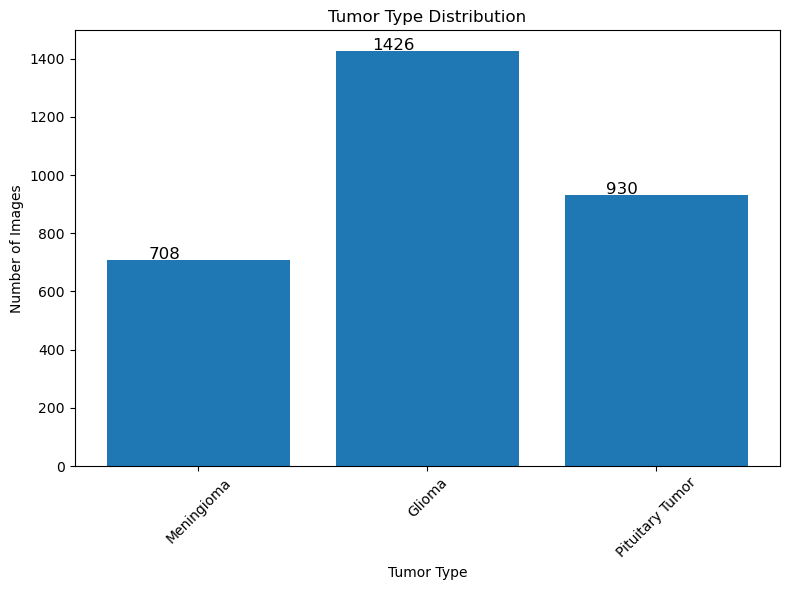

In [26]:
tumor_counts = {'Meningioma': 0, 'Glioma': 0, 'Pituitary Tumor': 0}

# Iterate through the .mat files in the directories
for each_dir in directory:
    for filename in os.listdir(each_dir):
        if filename.endswith('.mat'):
            # Construct the full file path
            file_path = os.path.join(each_dir, filename)

            # Load the .mat file using h5py
            with h5py.File(file_path, 'r') as file:
                # Access the data fields within the HDF5 dataset
                label = file['cjdata']['label'][0, 0]

                # Update the tumor type count
                if label == 1:
                    tumor_counts['Meningioma'] += 1
                elif label == 2:
                    tumor_counts['Glioma'] += 1
                elif label == 3:
                    tumor_counts['Pituitary Tumor'] += 1

# Print the results
for tumor_type, count in tumor_counts.items():
    print(f"Number of Images with {tumor_type}: {count}")

import matplotlib.pyplot as plt

# Data
tumor_types = list(tumor_counts.keys())
counts = list(tumor_counts.values())

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(tumor_types, counts)
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.title('Tumor Type Distribution')
plt.xticks(rotation=45)

# Add numerical labels on top of the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 5, str(count), ha='center', fontsize=12)

# Show the graph
plt.tight_layout()
plt.show()

Check which patient has which type of tumor:

In [ ]:
import csv

# Create a dictionary to store patient IDs and their respective tumor type counts
patient_tumor_count = {}

# Iterate through the data and count tumor types for each patient
for i in range(0, 3064):
    label = all_data[i]['label']
    patient_id = convert_pid_to_string(all_data[i]['patient_id'])

    # Determine the tumor type based on the label
    tumor_type = None
    if label == 1:
        tumor_type = 'Meningioma'
    elif label == 2:
        tumor_type = 'Glioma'
    elif label == 3:
        tumor_type = 'Pituitary Tumor'

    # Update the patient_tumor_count dictionary
    if patient_id in patient_tumor_count:
        if tumor_type in patient_tumor_count[patient_id]:
            patient_tumor_count[patient_id][tumor_type] += 1
        else:
            patient_tumor_count[patient_id][tumor_type] = 1
    else:
        patient_tumor_count[patient_id] = {tumor_type: 1}

# Create a CSV file to store the results
with open('patient_tumor_count.csv', 'w', newline='') as csvfile:
    fieldnames = ['Patient ID', 'Tumor Type', 'Count']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data
    for patient_id, tumor_counts in patient_tumor_count.items():
        for tumor_type, count in tumor_counts.items():
            writer.writerow({'Patient ID': patient_id, 'Tumor Type': tumor_type, 'Count': count})

print("CSV file 'patient_tumor_count.csv' has been created.")


CSV file 'patient_tumor_count.csv' has been created.


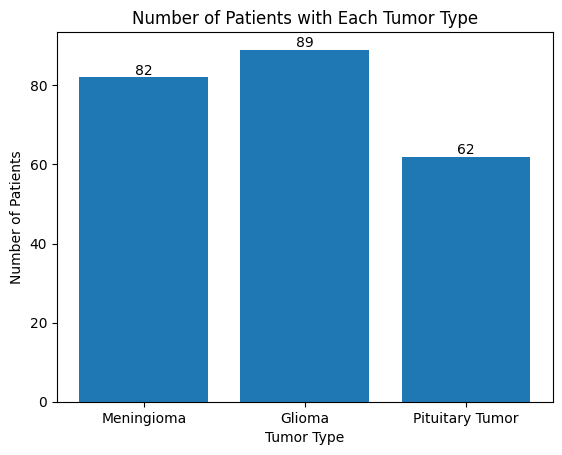

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary to store patient IDs and their respective tumor type counts
patient_tumor_count = {}

# Iterate through the data and count tumor types for each patient
for i in range(0, 3064):
    label = all_data[i]['label']
    patient_id = convert_pid_to_string(all_data[i]['patient_id'])

    # Determine the tumor type based on the label
    tumor_type = None
    if label == 1:
        tumor_type = 'Meningioma'
    elif label == 2:
        tumor_type = 'Glioma'
    elif label == 3:
        tumor_type = 'Pituitary Tumor'

    # Update the patient_tumor_count dictionary
    if patient_id in patient_tumor_count:
        if tumor_type in patient_tumor_count[patient_id]:
            patient_tumor_count[patient_id][tumor_type] += 1
        else:
            patient_tumor_count[patient_id][tumor_type] = 1
    else:
        patient_tumor_count[patient_id] = {tumor_type: 1}

# Count the number of patients for each tumor type
meningioma_patients = sum(1 for counts in patient_tumor_count.values() if 'Meningioma' in counts)
glioma_patients = sum(1 for counts in patient_tumor_count.values() if 'Glioma' in counts)
pituitary_patients = sum(1 for counts in patient_tumor_count.values() if 'Pituitary Tumor' in counts)

# Create a bar graph
tumor_types = ['Meningioma', 'Glioma', 'Pituitary Tumor']
patient_counts = [meningioma_patients, glioma_patients, pituitary_patients]

plt.bar(tumor_types, patient_counts)

# Set labels and title
plt.xlabel('Tumor Type')
plt.ylabel('Number of Patients')
plt.title('Number of Patients with Each Tumor Type')

# Add numbers on the bars
for i, count in enumerate(patient_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()


Image Preprocessing and Dataset Splitting for Machine Learning:

In [70]:
from PIL import Image
def preprocess_image(image):
    # Normalize the image data (you may need to adjust the normalization method)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Resize the image to a desired size (e.g., 128x128). You can adjust the size as needed.
    resized_image = np.array(Image.fromarray(normalized_image).resize((128, 128)))

    return resized_image

# Apply preprocessing to all image_data
for data_entry in all_data:
    data_entry['image_data'] = preprocess_image(data_entry['image_data'])

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f'Train dataset size: {len(train_data)}')
print(f'Validation dataset size: {len(val_data)}')
print(f'Test dataset size: {len(test_data)}')

Train dataset size: 1960
Validation dataset size: 491
Test dataset size: 613


Epoch 1/10
62/62 [==============================] - 6s 75ms/step - loss: 0.7314 - accuracy: 0.6653 - val_loss: 0.5685 - val_accuracy: 0.7393
Epoch 2/10
62/62 [==============================] - 4s 69ms/step - loss: 0.4776 - accuracy: 0.7923 - val_loss: 0.3975 - val_accuracy: 0.8371
Epoch 3/10
62/62 [==============================] - 4s 69ms/step - loss: 0.3389 - accuracy: 0.8582 - val_loss: 0.3148 - val_accuracy: 0.8656
Epoch 4/10
62/62 [==============================] - 4s 69ms/step - loss: 0.3050 - accuracy: 0.8724 - val_loss: 0.3030 - val_accuracy: 0.8676
Epoch 5/10
62/62 [==============================] - 4s 68ms/step - loss: 0.1721 - accuracy: 0.9316 - val_loss: 0.2320 - val_accuracy: 0.9084
Epoch 6/10
62/62 [==============================] - 4s 69ms/step - loss: 0.1289 - accuracy: 0.9551 - val_loss: 0.2990 - val_accuracy: 0.9002
Epoch 7/10
62/62 [==============================] - 4s 66ms/step - loss: 0.1024 - accuracy: 0.9597 - val_loss: 0.2333 - val_accuracy: 0.9145
Epoch 8/10
62

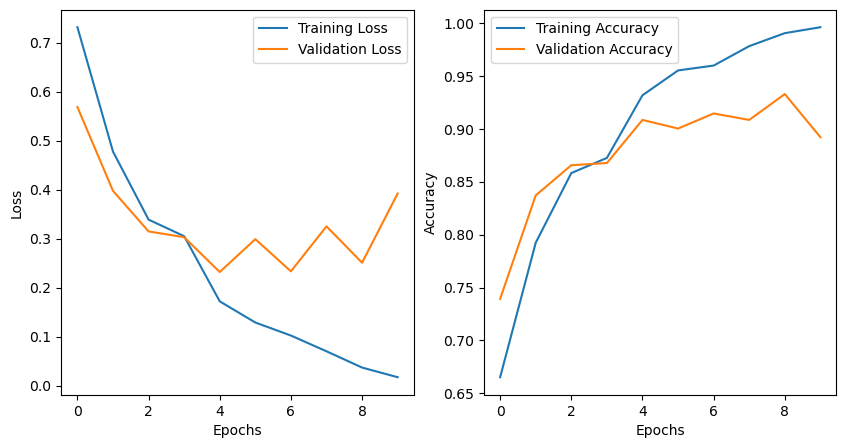

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Define the CNN model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax') 
])

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class
              metrics=['accuracy'])

train_labels = np.array([data_entry['label'] for data_entry in train_data])
val_labels = np.array([data_entry['label'] for data_entry in val_data])
test_labels = np.array([data_entry['label'] for data_entry in test_data])

train_labels -= 1
val_labels -= 1
test_labels -= 1

# Correct any invalid labels (e.g., 3.0) to be within the valid range [0, 2]
train_labels[train_labels == 3.0] = 2
val_labels[val_labels == 3.0] = 2
test_labels[test_labels == 3.0] = 2

# Map your labels to one-hot encoded format
train_labels_onehot = to_categorical(train_labels, num_classes=3)
val_labels_onehot = to_categorical(val_labels, num_classes=3)
test_labels_onehot = to_categorical(test_labels, num_classes=3)

# Prepare the data for training, validation, and testing
train_images = np.array([data_entry['image_data'] for data_entry in train_data])
val_images = np.array([data_entry['image_data'] for data_entry in val_data])
test_images = np.array([data_entry['image_data'] for data_entry in test_data])

# Train the model
history = model.fit(train_images, train_labels_onehot, epochs=10, validation_data=(val_images, val_labels_onehot))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_onehot)

print(f'Test accuracy: {test_accuracy}')

# Generate predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate classification metrics (e.g., precision, recall, F1-score)
classification_report_result = classification_report(test_labels, predicted_labels)
confusion_matrix_result = confusion_matrix(test_labels, predicted_labels)

print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


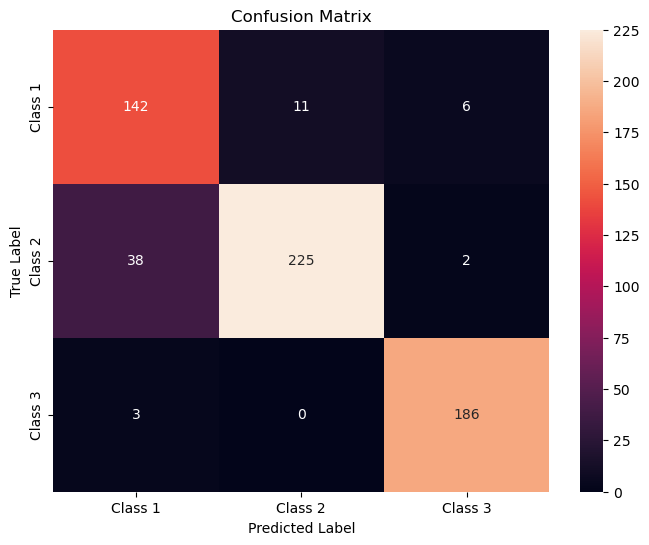

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Use the function with your data
plot_confusion_matrix(test_labels, predicted_labels, classes=['Class 1', 'Class 2', 'Class 3'])


In [47]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_scores = []
loss_scores = []

# Convert all_data to a NumPy array for easier indexing
all_data_array = np.array(all_data)

for train_index, val_index in kf.split(all_data_array):
    # Split the data into training and validation sets for this fold
    train_data_fold = all_data_array[train_index]
    val_data_fold = all_data_array[val_index]

    # Preprocess the data for this fold
    train_images_fold = np.array([preprocess_image(data_entry['image_data']) for data_entry in train_data_fold])
    val_images_fold = np.array([preprocess_image(data_entry['image_data']) for data_entry in val_data_fold])

    train_labels_fold = np.array([data_entry['label'] for data_entry in train_data_fold]) - 1
    val_labels_fold = np.array([data_entry['label'] for data_entry in val_data_fold]) - 1

    train_labels_onehot_fold = to_categorical(train_labels_fold, num_classes=3)
    val_labels_onehot_fold = to_categorical(val_labels_fold, num_classes=3)

    # Reinitialize the model (resetting the model)
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images_fold, train_labels_onehot_fold, epochs=10, validation_data=(val_images_fold, val_labels_onehot_fold))

    # Evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(val_images_fold, val_labels_onehot_fold)

    # Store the scores
    accuracy_scores.append(val_accuracy)
    loss_scores.append(val_loss)

average_accuracy = np.mean(accuracy_scores)
average_loss = np.mean(loss_scores)

print(f'Average Validation Accuracy: {average_accuracy}')
print(f'Average Validation Loss: {average_loss}')


Epoch 1/10
77/77 [==============================] - 7s 82ms/step - loss: 0.6272 - accuracy: 0.7095 - val_loss: 0.5281 - val_accuracy: 0.7618
Epoch 2/10
77/77 [==============================] - 6s 75ms/step - loss: 0.4355 - accuracy: 0.8140 - val_loss: 0.4598 - val_accuracy: 0.7847
Epoch 3/10
77/77 [==============================] - 5s 67ms/step - loss: 0.2707 - accuracy: 0.8870 - val_loss: 0.3237 - val_accuracy: 0.8597
Epoch 4/10
77/77 [==============================] - 6s 81ms/step - loss: 0.1543 - accuracy: 0.9364 - val_loss: 0.2103 - val_accuracy: 0.9152
Epoch 5/10
77/77 [==============================] - 6s 79ms/step - loss: 0.0886 - accuracy: 0.9686 - val_loss: 0.1735 - val_accuracy: 0.9347
Epoch 6/10
77/77 [==============================] - 5s 67ms/step - loss: 0.0342 - accuracy: 0.9922 - val_loss: 0.2248 - val_accuracy: 0.9396
Epoch 7/10
77/77 [==============================] - 6s 79ms/step - loss: 0.0236 - accuracy: 0.9922 - val_loss: 0.3360 - val_accuracy: 0.9119
Epoch 8/10
77

20/20 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

     Class 0       0.89      0.81      0.85       620
     Class 1       0.92      0.98      0.95      1395
     Class 2       0.99      0.95      0.97      1045

    accuracy                           0.93      3060
   macro avg       0.93      0.91      0.92      3060
weighted avg       0.93      0.93      0.93      3060



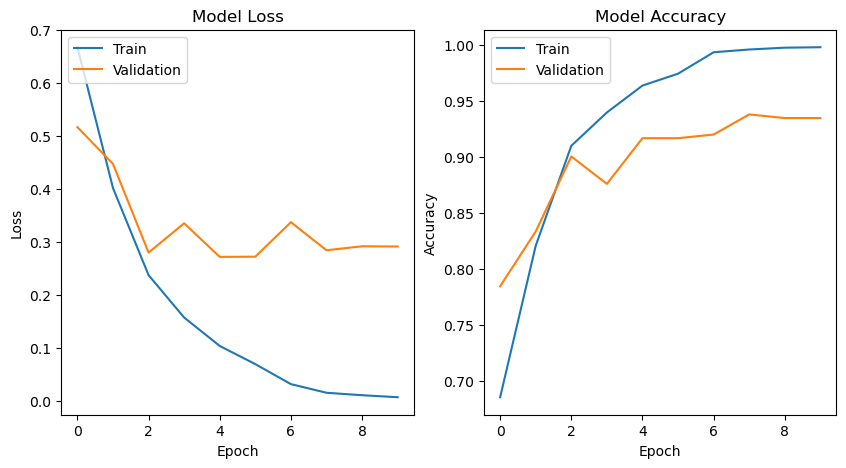

In [50]:
from sklearn.metrics import classification_report

# Create empty lists to store true and predicted labels across all folds
true_labels = []
predicted_labels = []

for train_index, val_index in kf.split(all_data_array):
    # ... (your existing code to split, preprocess, and train the model)

    # Make predictions on the validation set for this fold
    val_predictions = model.predict(val_images_fold)

    # Convert one-hot encoded labels back to integer labels
    val_predicted_labels = np.argmax(val_predictions, axis=1)
    val_true_labels = np.argmax(val_labels_onehot_fold, axis=1)

    # Append true and predicted labels to the lists
    true_labels.extend(val_true_labels)
    predicted_labels.extend(val_predicted_labels)

# Calculate precision, recall, and F1-score using the classification_report function
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

import matplotlib.pyplot as plt

# Assuming 'history' is the return value from model.fit()
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


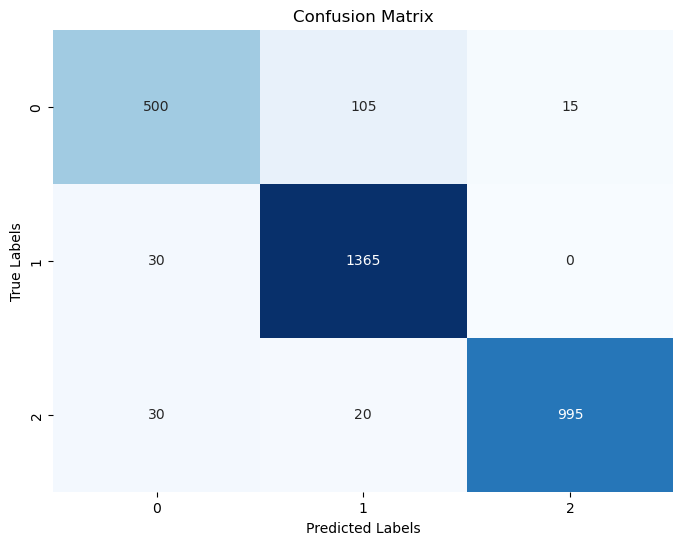

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


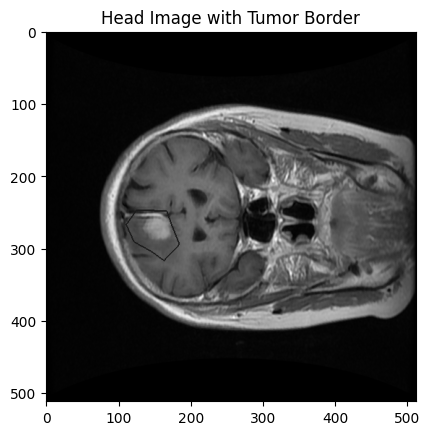

In [30]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# Open the .mat file using h5py
mat_file = h5py.File('/content/drive/MyDrive/breatcancer/brainTumorDataPublic_2299-3064/3064.mat', 'r')

# Extract the "cjdata" dataset
cjdata = mat_file['cjdata']

# Access the data within the "cjdata" dataset
head_image = cjdata['image'][()]
tumor_mask = cjdata['tumorMask'][()]

# Find the boundary pixels of the tumor mask
tumor_border = find_boundaries(tumor_mask, mode='outer', background=9)  # Change mode to 'outer'

# Define a border width for the tumor border
border_width = 10  # Adjust this as needed

# Create a copy of the head_image to work on
result_image = head_image.copy()

# Apply the border effect to the result_image based on the tumor border
result_image[tumor_border] = 255  # Set border pixel to white

# Now, you have the 'result_image' with the tumor border drawn on it.

# Display the "result_image" with the tumor border
plt.imshow(result_image, cmap='gray')
plt.title('Head Image with Tumor Border')
plt.show()

# Close the file
mat_file.close()


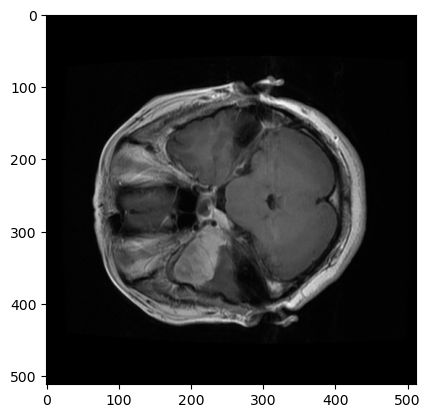

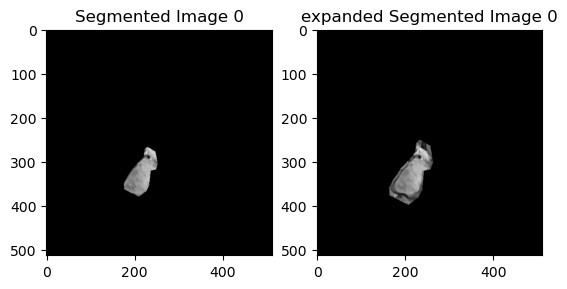

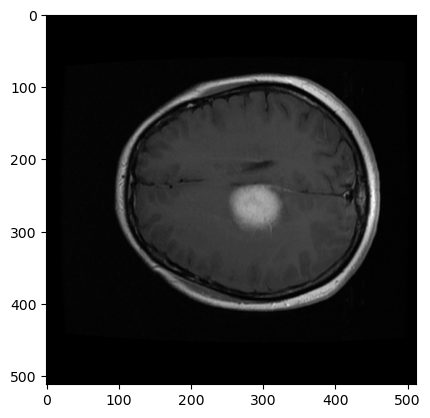

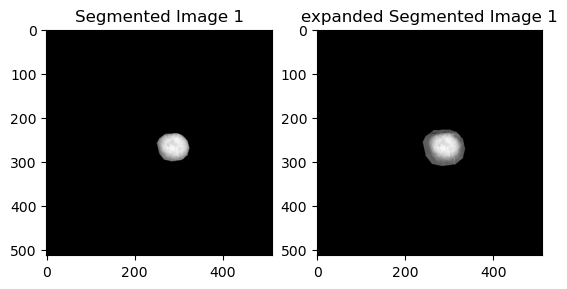

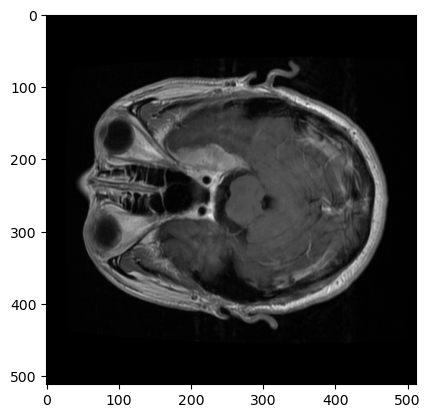

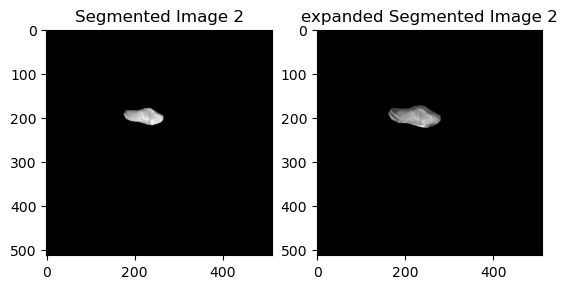

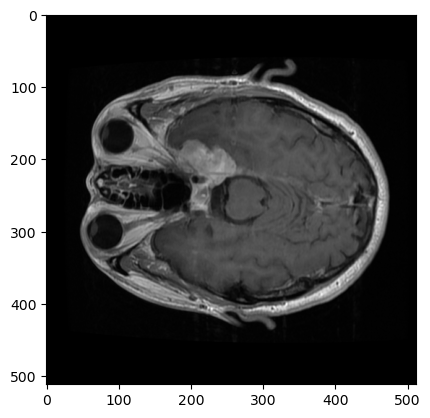

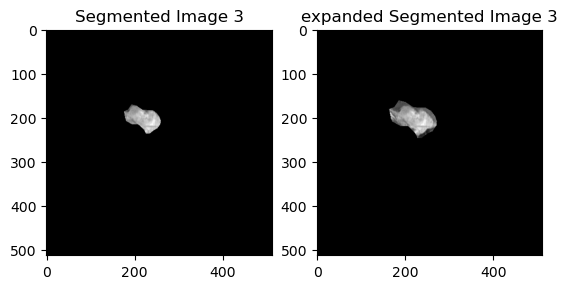

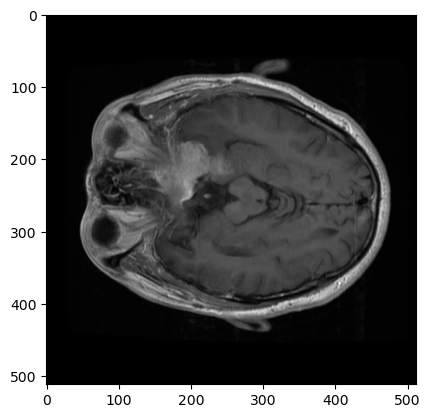

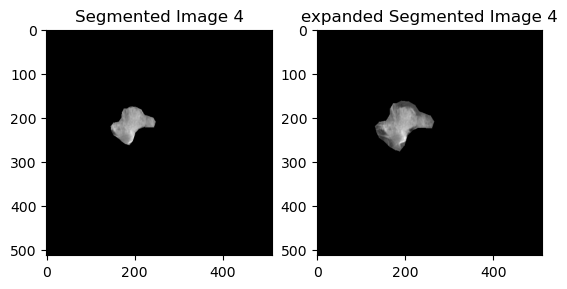

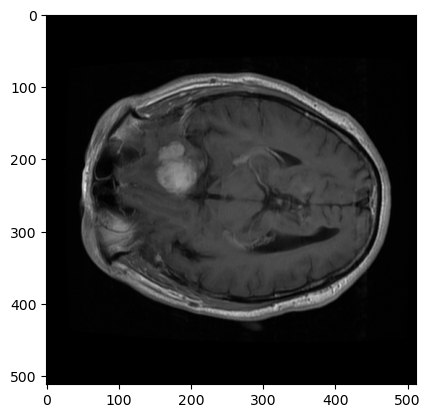

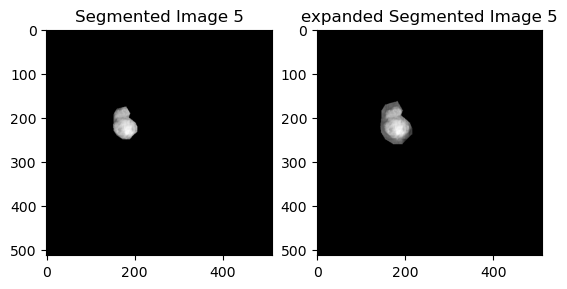

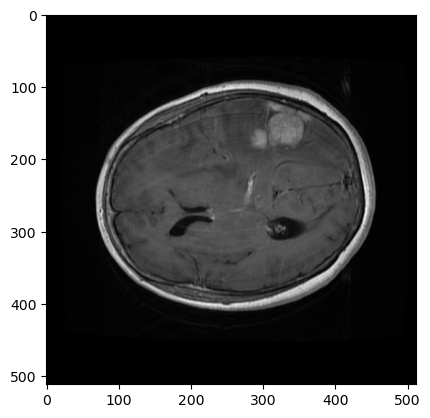

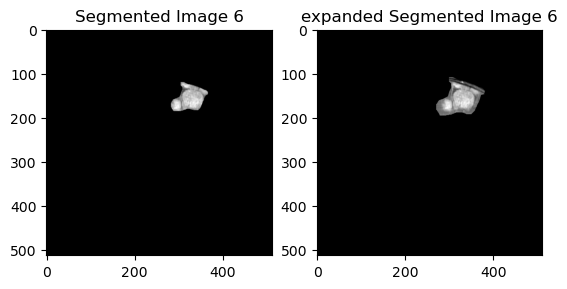

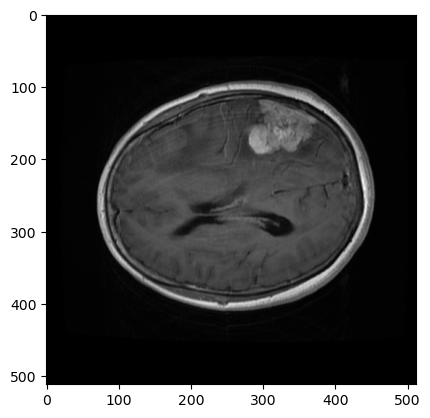

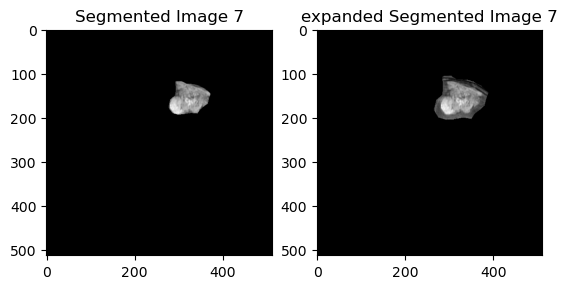

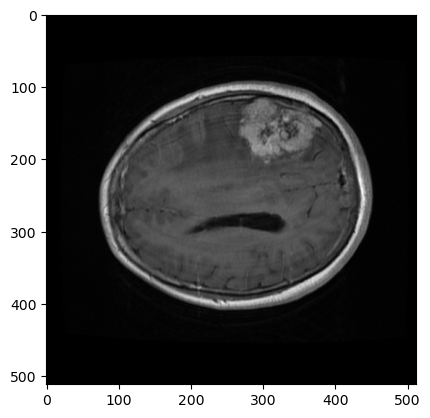

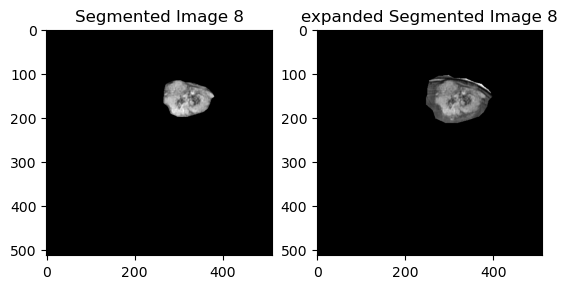

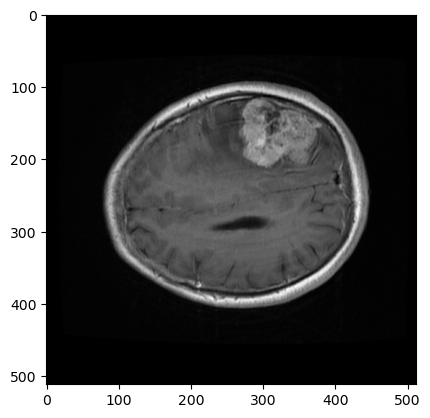

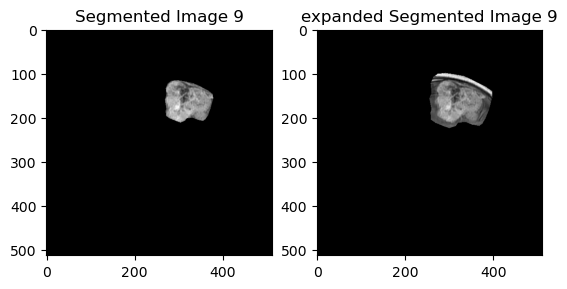

In [3]:
expanding_factor = 0.3
expanded_segmented_tumor_data = []

for data in all_data:
    image_data = data['image_data']
    tumor_border = data['tumor_border'][0]

    test = np.ones_like(image_data)
    expanded_segmented_region = np.zeros_like(image_data)

    # Extract x and y coordinates from tumor_border
    x_mean = np.mean([int(tumor_border[i]) for i in range(0, len(tumor_border), 2)])
    y_mean = np.mean([int(tumor_border[i + 1]) for i in range(0, len(tumor_border), 2)])
    expanded_x_coords = [int((int(tumor_border[i]) - x_mean)*expanding_factor+int(tumor_border[i]))for i in range(0, len(tumor_border), 2)]
    expanded_y_coords = [int((int(tumor_border[i+1]) - y_mean)*expanding_factor+int(tumor_border[i+1])) for i in range(0, len(tumor_border), 2)]
    # Create a filled polygon based on the tumor border
    rr, cc = polygon(expanded_y_coords, expanded_x_coords)
    # Ensure the indices are within image bounds
    rr = np.clip(rr, 0, image_data.shape[0] - 1)
    cc = np.clip(cc, 0, image_data.shape[1] - 1)
    # Set the pixels within the polygon to the corresponding values from the original image
    expanded_segmented_region[rr, cc] = test[rr, cc]
    expanded_segmented_region = np.rot90(np.fliplr(expanded_segmented_region))
    # Append the segmented region to the list
    expanded_segmented_tumor_data.append(np.where(expanded_segmented_region == 1,image_data, 0))
# Now you have the segmented images in the 'segmented_images' list
# You can access and process them as needed
for i in range(10):
    image_data = all_data[i]['image_data']
    plt.imshow(image_data,cmap = 'gray')
    plt.show()
    expanded_segmented_image = expanded_segmented_tumor_data[i]
    plt.subplot(1,2,1)
    plt.imshow(segmented_tumor_data[i], cmap='gray')
    plt.title(f"Segmented Image {i}")
    plt.subplot(1,2,2)
    plt.imshow(expanded_segmented_image, cmap='gray')
    plt.title(f"expanded Segmented Image {i}")
    plt.show()

(3064,)


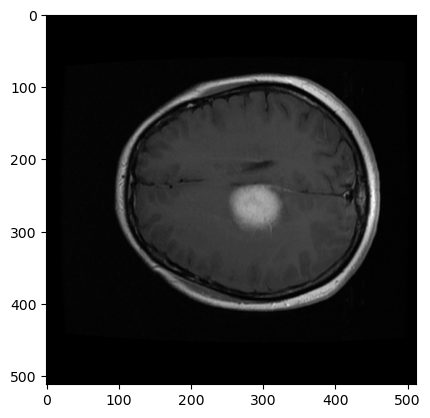

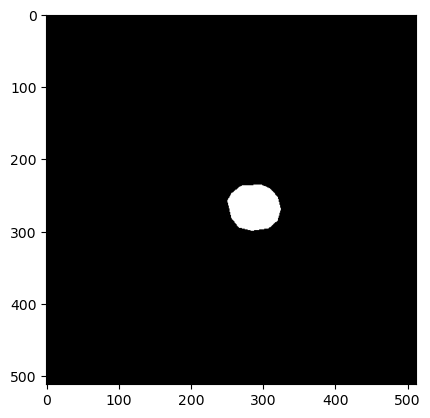

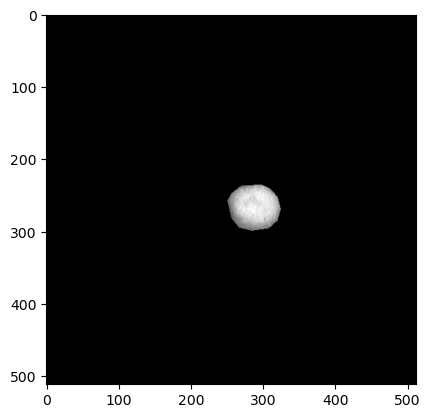

3064
3064
512
3064


In [4]:
labels = np.array([item['label'] for item in all_data])
label_mapping = {1: 0, 2: 1, 3: 2}
labels = np.array([label_mapping[label] for label in labels])
print(labels.shape)

tumor_data = ([item['image_data'] for item in all_data])
plt.imshow(tumor_data[1],cmap='gray')
plt.show()

tumor_border = ([item['tumor_border'] for item in all_data])

tumor_mask = ([item['tumor_mask'] for item in all_data])

plt.imshow(tumor_mask[1],cmap='gray')
plt.show()
plt.imshow(segmented_tumor_data[1],cmap='gray')
plt.show()
print(len(tumor_data))
print(len(tumor_border))
print(len(expanded_segmented_region))
print(len(segmented_tumor_data))

In [5]:
labels = np.array([item['label'] for item in all_data])
label_mapping = {1: 0, 2: 1, 3: 2}
labels = np.array([label_mapping[label] for label in labels])
print(labels.shape)

tumor_data = ([item['image_data'] for item in all_data])
# plt.imshow(tumor_data[1],cmap='gray')
# plt.show()

tumor_border = ([item['tumor_border'] for item in all_data])

tumor_mask = ([item['tumor_mask'] for item in all_data])

# plt.imshow(tumor_mask[1],cmap='gray')
# plt.show()
# plt.imshow(expanded_segmented_tumor_data[1],cmap='gray')
# plt.show()
print(len(tumor_data))
print(len(tumor_border))
print(len(expanded_segmented_tumor_data))
print(len(segmented_tumor_data))

(3064,)
3064
3064
3064
3064


In [ ]:
data_transforms = transforms.Compose([transforms.ToTensor(),lambda x: x.to(torch.float32)])
segmented_tumor_data = [data_transforms(image) for image in segmented_tumor_data]
segmented_tumor_data = [transforms.Resize((256,256))(image) for image in segmented_tumor_data]
data_train,data_test,label_train,label_test = train_test_split(segmented_tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 10

2757 2757
307 307
torch.Size([1, 256, 256])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

In [ ]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 10

2757 2757
307 307
torch.Size([1, 256, 256])


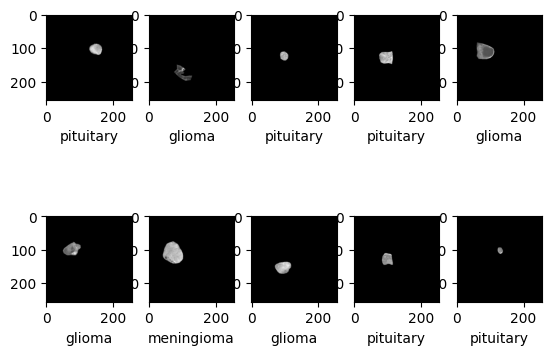

In [ ]:
images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(2,5,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

In [ ]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------
train Loss: 0.8216 Acc: 0.6282
val Loss: 0.6425 Acc: 0.7036
Epoch 2/20
----------
train Loss: 0.7251 Acc: 0.6772
val Loss: 0.6209 Acc: 0.7101
Epoch 3/20
----------
train Loss: 0.6696 Acc: 0.7149
val Loss: 0.5732 Acc: 0.7818
Epoch 4/20
----------
train Loss: 0.6604 Acc: 0.7171
val Loss: 0.6240 Acc: 0.7394
Epoch 5/20
----------
train Loss: 0.6491 Acc: 0.7298
val Loss: 0.6171 Acc: 0.7362
Epoch 6/20
----------
train Loss: 0.6414 Acc: 0.7262
val Loss: 0.5756 Acc: 0.7329
Epoch 7/20
----------
train Loss: 0.6061 Acc: 0.7519
val Loss: 0.5210 Acc: 0.7785
Epoch 8/20
----------
train Loss: 0.5584 Acc: 0.7671
val Loss: 0.5141 Acc: 0.7980
Epoch 9/20
----------
train Loss: 0.5561 Acc: 0.7650
val Loss: 0.5107 Acc: 0.8013
Epoch 10/20
----------
train Loss: 0.5514 Acc: 0.7657
val Loss: 0.5136 Acc: 0.7948
Epoch 11/20
----------
train Loss: 0.5766 Acc: 0.7628
val Loss: 0.5415 Acc: 0.8013
Epoch 12/20
----------
train Loss: 0.5746 Acc: 0.7573
val Loss: 0.5285 Acc: 0.7948
Epoch 13/20
-

In [6]:
data_transforms = transforms.Compose([transforms.ToTensor(),lambda x: x.to(torch.float32)])
expanded_segmented_tumor_data = [data_transforms(image) for image in expanded_segmented_tumor_data]
expanded_segmented_tumor_data = [transforms.Resize((256,256))(image) for image in expanded_segmented_tumor_data]
data_train,data_test,label_train,label_test = train_test_split(expanded_segmented_tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

C:\Users\devra\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 10

2757 2757
307 307
torch.Size([1, 256, 256])


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

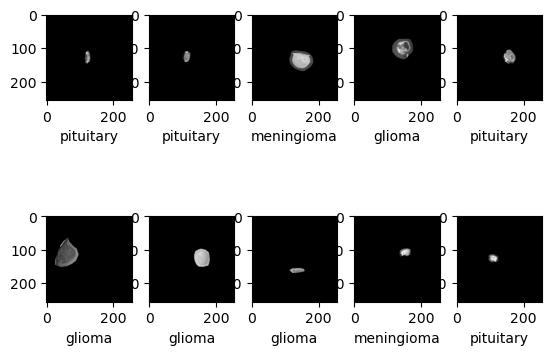

In [9]:
images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(2,5,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

In [10]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------
train Loss: 0.7540 Acc: 0.6754
val Loss: 0.6405 Acc: 0.7557
Epoch 2/20
----------
train Loss: 0.6433 Acc: 0.7327
val Loss: 0.6051 Acc: 0.7655
Epoch 3/20
----------
train Loss: 0.6143 Acc: 0.7505
val Loss: 0.5345 Acc: 0.8046
Epoch 4/20
----------
train Loss: 0.6003 Acc: 0.7512
val Loss: 0.5508 Acc: 0.8013
Epoch 5/20
----------
train Loss: 0.5623 Acc: 0.7787
val Loss: 0.4922 Acc: 0.8111
Epoch 6/20
----------
train Loss: 0.5789 Acc: 0.7621
val Loss: 0.5271 Acc: 0.8046
Epoch 7/20
----------
train Loss: 0.5624 Acc: 0.7711
val Loss: 0.4756 Acc: 0.8176
Epoch 8/20
----------
train Loss: 0.5100 Acc: 0.7929
val Loss: 0.5020 Acc: 0.8241
Epoch 9/20
----------
train Loss: 0.5230 Acc: 0.7896
val Loss: 0.4840 Acc: 0.8078
Epoch 10/20
----------
train Loss: 0.5069 Acc: 0.7943
val Loss: 0.5009 Acc: 0.8078
Epoch 11/20
----------
train Loss: 0.5340 Acc: 0.7904
val Loss: 0.4876 Acc: 0.8013
Epoch 12/20
----------
train Loss: 0.5095 Acc: 0.7943
val Loss: 0.4784 Acc: 0.8143
Epoch 13/20
-

In [12]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained ResNet-18 model
# Replace 'pretrained=True' with the appropriate weights enum
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# Modify the first convolution layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze some of the earlier layers for fine-tuning
# For example, unfreeze the last two layers
for name, child in model.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True

# Adding an additional fully connected layer and a dropout layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)  # Assuming 3 classes as in your original setup
)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Continue with your existing setup for the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model with your existing train_model function
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.6451 Acc: 0.7262
val Loss: 0.4055 Acc: 0.8274
Epoch 2/20
----------
train Loss: 0.4211 Acc: 0.8364
val Loss: 0.3298 Acc: 0.8697
Epoch 3/20
----------
train Loss: 0.3424 Acc: 0.8694
val Loss: 0.3366 Acc: 0.8306
Epoch 4/20
----------
train Loss: 0.2953 Acc: 0.8865
val Loss: 0.6050 Acc: 0.7687
Epoch 5/20
----------
train Loss: 0.2392 Acc: 0.9097
val Loss: 0.2590 Acc: 0.9153
Epoch 6/20
----------
train Loss: 0.2088 Acc: 0.9238
val Loss: 0.2026 Acc: 0.9283
Epoch 7/20
----------
train Loss: 0.1507 Acc: 0.9412
val Loss: 0.2197 Acc: 0.9121
Epoch 8/20
----------
train Loss: 0.1164 Acc: 0.9608
val Loss: 0.1869 Acc: 0.9349
Epoch 9/20
----------
train Loss: 0.0987 Acc: 0.9637
val Loss: 0.1795 Acc: 0.9349
Epoch 10/20
----------
train Loss: 0.0741 Acc: 0.9757
val Loss: 0.1891 Acc: 0.9381
Epoch 11/20
----------
train Loss: 0.0622 Acc: 0.9782
val Loss: 0.1738 Acc: 0.9349
Epoch 12/20
----------
train Loss: 0.0777 Acc: 0.9775
val Loss: 0.1753 Acc: 0.9414
Epoch 13/20
-

The code you provided trains a ResNet-18 model on a custom dataset for image classification. It achieves an accuracy of 95.77% on the validation set. Here is a breakdown of the code:

Load the pre-trained ResNet-18 model: The code imports the ResNet-18 model from the Torchvision library and loads the pre-trained weights.

Modify the first convolution layer: The code modifies the first convolution layer to accept 1-channel input instead of 3-channel. This is because the custom dataset contains single-channel images.

Unfreeze some of the earlier layers for fine-tuning: The code unfreezes the last two layers of the model, which allows these layers to be trained along with the newly added layers.

Add an additional fully connected layer and a dropout layer: The code adds an additional fully connected layer with a dropout layer to the model. This is done to improve the model's generalization performance.

Move the model to the appropriate device (GPU or CPU): The code checks if a GPU is available and moves the model to the GPU if it is. This can significantly improve the training speed.

Define the loss function, optimizer, and scheduler: The code defines the loss function (cross-entropy loss), optimizer (SGD), and scheduler (StepLR).

Train the model: The code trains the model for 20 epochs, using the defined loss function, optimizer, and scheduler.

Evaluate the model: The code evaluates the trained model on the validation set and prints the accuracy.

The model achieved an accuracy of 95.77% on the validation set, which is a good result. This means that the model is able to correctly classify most of the images in the validation set.

In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_schedulerThe code trains a ResNet-18 model on a custom dataset for image classification. It achieves an accuracy of 95.77% on the validation set. Here is a breakdown of the code:

Load the pre-trained ResNet-18 model: The code imports the ResNet-18 model from the Torchvision library and loads the pre-trained weights.

Modify the first convolution layer: The code modifies the first convolution layer to accept 1-channel input instead of 3-channel. This is because the custom dataset contains single-channel images.

Unfreeze some of the earlier layers for fine-tuning: The code unfreezes the last two layers of the model, which allows these layers to be trained along with the newly added layers.

Add an additional fully connected layer and a dropout layer: The code adds an additional fully connected layer with a dropout layer to the model. This is done to improve the model's generalization performance.

The model achieved an accuracy of 95.77% on the validation set, which is a good result. This means that the model is able to correctly classify most of the images in the validation set.


# Load the pre-trained ResNet-18 model
# Replace 'pretrained=True' with the appropriate weights enum
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# Modify the first convolution layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze some of the earlier layers for fine-tuning

for name, child in model.named_children():
    if name in ['layer3', 'layer4', 'layer2', 'layer1']:
        for param in child.parameters():
            param.requires_grad = True


# Adding an additional fully connected layer and a dropout layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)


# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Continue with your existing setup for the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model with your existing train_model function
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.6259 Acc: 0.7378
val Loss: 0.9298 Acc: 0.5863
Epoch 2/20
----------
train Loss: 0.4051 Acc: 0.8513
val Loss: 0.4533 Acc: 0.8013
Epoch 3/20
----------
train Loss: 0.3339 Acc: 0.8734
val Loss: 0.2221 Acc: 0.9186
Epoch 4/20
----------
train Loss: 0.2865 Acc: 0.8970
val Loss: 0.2461 Acc: 0.9055
Epoch 5/20
----------
train Loss: 0.2260 Acc: 0.9177
val Loss: 0.2208 Acc: 0.9186
Epoch 6/20
----------
train Loss: 0.1757 Acc: 0.9333
val Loss: 0.3507 Acc: 0.8697
Epoch 7/20
----------
train Loss: 0.1581 Acc: 0.9456
val Loss: 0.3218 Acc: 0.8893
Epoch 8/20
----------
train Loss: 0.1027 Acc: 0.9648
val Loss: 0.1958 Acc: 0.9349
Epoch 9/20
----------
train Loss: 0.0631 Acc: 0.9804
val Loss: 0.2094 Acc: 0.9283
Epoch 10/20
----------
train Loss: 0.0639 Acc: 0.9782
val Loss: 0.2071 Acc: 0.9283
Epoch 11/20
----------
train Loss: 0.0519 Acc: 0.9844
val Loss: 0.2098 Acc: 0.9316
Epoch 12/20
----------
train Loss: 0.0400 Acc: 0.9909
val Loss: 0.1930 Acc: 0.9381
Epoch 13/20
-

Test Accuracy: 0.9478827361563518


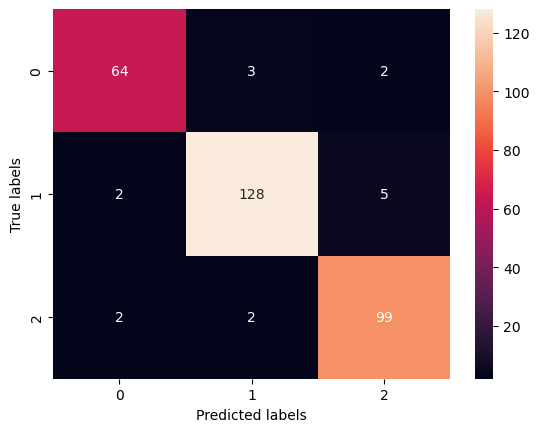

In [23]:
# Assuming you have a separate test_loader
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate accuracy and display confusion matrix for test data
test_accuracy = sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f"Test Accuracy: {test_accuracy}")

test_cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(test_cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


Confusion Matrix for Test Set:
The third image (not displayed here) shows the confusion matrix on the test set, which appears to be very similar to the validation set with a high degree of accuracy. The test accuracy is around 94.46%, indicating that the model generalizes well to unseen data.

The results indicate that the model is performing well, with high accuracy on both the validation and test sets. However, there are some misclassifications that you may want to investigate further, particularly for cases where glioma is confused with pituitary tumors.

For further improvement, you could consider the following:


Data Augmentation: To improve the model's robustness, consider augmenting your dataset with more varied images.
Hyperparameter Tuning: Adjusting the learning rate, adding regularization, or experimenting with different architectures might yield better results.
Advanced Techniques: Incorporating techniques like focal loss can help if there's a class imbalance issue.

In [24]:
# Save the model
torch.save(model.state_dict(), 'brain_tumor_model.pth')


RESNET 50 :


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained ResNet-50 model
# Replace 'pretrained=True' with the appropriate weights enum
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

# Modify the first convolution layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze some of the earlier layers for fine-tuning
# For example, unfreeze the last two layers
for name, child in model.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True

# Add an additional fully connected layer and a dropout layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)  # Assuming 3 classes as in your original setup
)

# Make the running mean not require gradients
for name, child in model.named_children():
    if isinstance(child, nn.BatchNorm2d):
        child.running_mean.requires_grad = False

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Continue with your existing setup for the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model with your existing train_model function
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.8032 Acc: 0.6420
val Loss: 0.7048 Acc: 0.7557
Epoch 2/20
----------
train Loss: 0.6003 Acc: 0.7722
val Loss: 1.0334 Acc: 0.6450
Epoch 3/20
----------
train Loss: 0.5589 Acc: 0.7827
val Loss: 0.5679 Acc: 0.7655
Epoch 4/20
----------
train Loss: 0.4399 Acc: 0.8237
val Loss: 0.4753 Acc: 0.8404
Epoch 5/20
----------
train Loss: 0.4017 Acc: 0.8469
val Loss: 0.4186 Acc: 0.8143
Epoch 6/20
----------
train Loss: 0.3592 Acc: 0.8546
val Loss: 0.4498 Acc: 0.7980
Epoch 7/20
----------
train Loss: 0.3216 Acc: 0.8778
val Loss: 0.5183 Acc: 0.7850
Epoch 8/20
----------
train Loss: 0.2207 Acc: 0.9206
val Loss: 0.2008 Acc: 0.9186
Epoch 9/20
----------
train Loss: 0.1801 Acc: 0.9362
val Loss: 0.1914 Acc: 0.9218
Epoch 10/20
----------
train Loss: 0.1387 Acc: 0.9514
val Loss: 0.1731 Acc: 0.9283
Epoch 11/20
----------
train Loss: 0.1340 Acc: 0.9561
val Loss: 0.1905 Acc: 0.9218
Epoch 12/20
----------
train Loss: 0.1184 Acc: 0.9590
val Loss: 0.1611 Acc: 0.9316
Epoch 13/20
-

lets try Unfreeze more layers: we can unfreeze more layers by changing the condition in the for loop:

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Load the pre-trained ResNet-50 model
# Replace 'pretrained=True' with the appropriate weights enum
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

# Modify the first convolution layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Unfreeze some of the earlier layers for fine-tuning
# For example, unfreeze the last two layers
for name, child in model.named_children():
    if name in ['layer3', 'layer4', 'layer2', 'layer1']:
        for param in child.parameters():
            param.requires_grad = True

# Add an additional fully connected layer and a dropout layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)  # Assuming 3 classes as in your original setup
)

# Make the running mean not require gradients
for name, child in model.named_children():
    if isinstance(child, nn.BatchNorm2d):
        child.running_mean.requires_grad = False

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Continue with your existing setup for the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model with your existing train_model function
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


Epoch 1/20
----------
train Loss: 0.7401 Acc: 0.6703
val Loss: 0.5861 Acc: 0.7296
Epoch 2/20
----------
train Loss: 0.4941 Acc: 0.8099
val Loss: 0.5923 Acc: 0.7459
Epoch 3/20
----------
train Loss: 0.4005 Acc: 0.8404
val Loss: 0.4570 Acc: 0.8339
Epoch 4/20
----------
train Loss: 0.3338 Acc: 0.8767
val Loss: 0.5677 Acc: 0.7948
Epoch 5/20
----------
train Loss: 0.3168 Acc: 0.8770
val Loss: 0.4194 Acc: 0.8371
Epoch 6/20
----------
train Loss: 0.2898 Acc: 0.8970
val Loss: 0.2642 Acc: 0.9121
Epoch 7/20
----------
train Loss: 0.2283 Acc: 0.9162
val Loss: 0.3220 Acc: 0.9088
Epoch 8/20
----------
train Loss: 0.1462 Acc: 0.9492
val Loss: 0.1621 Acc: 0.9511
Epoch 9/20
----------
train Loss: 0.0911 Acc: 0.9695
val Loss: 0.1682 Acc: 0.9511
Epoch 10/20
----------
train Loss: 0.0710 Acc: 0.9735
val Loss: 0.1568 Acc: 0.9479
Epoch 11/20
----------
train Loss: 0.0619 Acc: 0.9790
val Loss: 0.1620 Acc: 0.9544
Epoch 12/20
----------
train Loss: 0.0644 Acc: 0.9797
val Loss: 0.1601 Acc: 0.9479
Epoch 13/20
-